In [1]:
from Detector.detector import Detector
from PIL import Image
import torch
from torchvision import transforms
import Detector.visualize as visualize  # TODO check imports
import re
import glob
import os
import numpy as np

In [2]:
detector = Detector()

In [10]:
test_video_path = "/media/sil2/regev/pose_estimation/Arena/output/20200521-195335/19506481-0000.avi"
d = visualize.save_pred_video(test_video_path, "labelled/test.mp4", detector,num_frames=1000)

100%|██████████| 1000/1000 [00:56<00:00, 17.73it/s]

Read :  0.010936004161834717
BGR2RGB :  0.004236973524093628
fromarray :  0.0010417060852050781
resize_image :  0.015751302242279053
Inference :  0.01599158787727356
Detect_draw :  0.0006421380043029785
Write :  0.0074131379127502445


In [8]:
for k in d.keys():
    print(k,": ",round(1/d[k].mean()))
d['Total'] = np.sum(np.stack([d[k] for k in d.keys() if k!='Total'],axis=1),axis=1)
print("Average FPS: ",round(1/d['Total'].mean()))

Read :  91.0
BGR2RGB :  228.0
fromarray :  977.0
resize_image :  69.0
Inference :  65.0
Detect_draw :  1877.0
Write :  134.0
Total :  18.0
Average FPS:  18.0


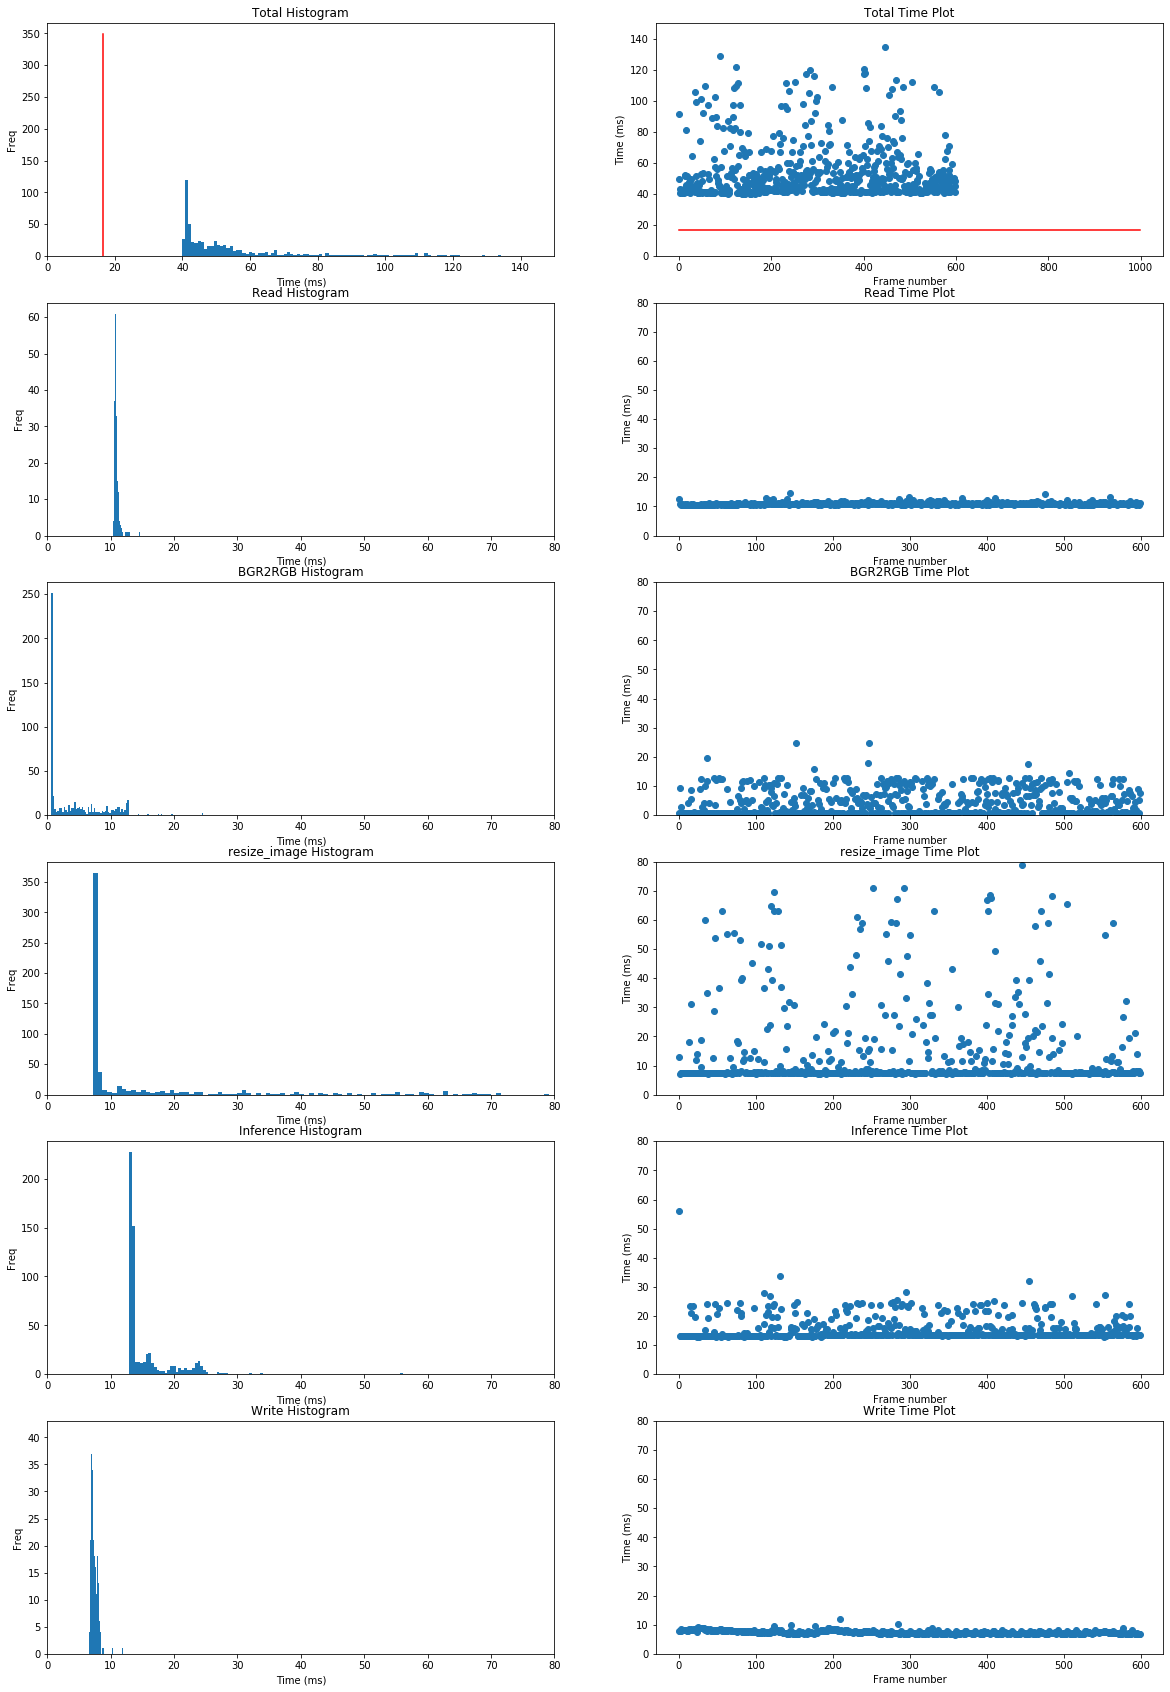

In [9]:
import matplotlib.pyplot as plt
import numpy as np
phases = ['Read','BGR2RGB','resize_image','Inference','Write']
fig,axs = plt.subplots(len(phases)+1,2,figsize=(20,30))
k='Total'
axs[0][0].set_title(k+' Histogram')
axs[0][1].set_title(k+' Time Plot')
axs[0][0].hist(d[k]*1000,label=k,bins=100)
axs[0][0].set_xlim(0,150)
axs[0][0].set_xlabel('Time (ms)')
axs[0][1].set_xlabel('Frame number')
axs[0][0].set_ylabel('Freq')
axs[0][1].set_ylabel('Time (ms)')
axs[0][1].scatter(np.arange(d[k].shape[0]),d[k]*1000)
axs[0][1].set_ylim(0,150)
axs[0][0].plot(np.ones(350)*16.6,np.arange(350),color='r')
axs[0][1].plot(np.arange(1000),np.ones(1000)*16.6,color='r')
for i,k in enumerate(phases):
    i+=1
    axs[i][0].set_title(k+' Histogram')
    axs[i][1].set_title(k+' Time Plot')
    axs[i][0].hist(d[k]*1000,label=k,bins=100)
    axs[i][0].set_xlim(0,80)
    axs[i][0].set_xlabel('Time (ms)')
    axs[i][1].set_xlabel('Frame number')
    axs[i][0].set_ylabel('Freq')
    axs[i][1].set_ylabel('Time (ms)')
    axs[i][1].scatter(np.arange(d[k].shape[0]),d[k]*1000)
    axs[i][1].set_ylim(0,80)
#plt.savefig('timings.jpg')

In [3]:
test_video_path = "/media/sil2/regev/pose_estimation/Arena/output/20200521-195335/19506481-0000.avi"
vid_name = '19506481-0000.avi'
path_to = '/media/sil2/regev/pose_estimation/Arena/output/20200521'
L = glob.glob(path_to+'*')
video_paths = []
output_paths = []
for file in L:
    vid_time = re.search('20200521-(\d+)',file).group(1)
    p = os.path.join(path_to+'-'+vid_time,vid_name)
    if os.path.exists(p):
        video_paths.append(p)
        output_paths.append("labelled/arrow_" + vid_time + ".mp4")
        
video_paths

['/media/sil2/regev/pose_estimation/Arena/output/20200521-172245/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172519/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172637/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172842/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173206/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173410/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173606/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174011/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174247/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174430/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-175816/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-180046/

In [18]:
for i in range(len(video_paths)):
    inf_time = visualize.save_pred_video(video_paths[i], output_paths[i], detector)
    print("Inference framerate:", 1/inf_time)

  3%|▎         | 3/100 [00:00<00:04, 22.94it/s]

Inference framerate: 58.435209050252865


  1%|          | 3/300 [00:00<00:11, 24.79it/s]

Inference framerate: 69.91467993515775


  1%|          | 2/300 [00:00<00:17, 17.04it/s]

Inference framerate: 71.99989151017324


  1%|          | 2/300 [00:00<00:24, 11.94it/s]

Inference framerate: 71.76860221755865


  1%|          | 3/300 [00:00<00:12, 23.20it/s]

Inference framerate: 70.96067370646438


  1%|          | 3/300 [00:00<00:12, 24.39it/s]

Inference framerate: 72.58725024847304


  1%|          | 2/300 [00:00<00:18, 16.31it/s]

Inference framerate: 70.33384523181489


  1%|          | 3/300 [00:00<00:13, 21.39it/s]

Inference framerate: 69.82446983279355


  0%|          | 1/300 [00:00<00:30,  9.73it/s]

Inference framerate: 69.24199760405494


  0%|          | 3/1000 [00:00<00:43, 22.69it/s]

Inference framerate: 72.95575619607894


  0%|          | 1/1000 [00:00<01:56,  8.61it/s]

Inference framerate: 71.75666611145107


  0%|          | 3/1000 [00:00<00:48, 20.44it/s]

Inference framerate: 71.46197172256753


  3%|▎         | 3/100 [00:00<00:05, 19.19it/s]

Inference framerate: 71.23856957749283


  0%|          | 3/1000 [00:00<00:42, 23.62it/s]

Inference framerate: 69.49759070940564


  0%|          | 3/1000 [00:00<00:45, 21.78it/s]

Inference framerate: 69.75047636089214


  0%|          | 0/1000 [00:00<?, ?it/s]

Inference framerate: 69.85266319873497


  0%|          | 1/1000 [00:00<02:07,  7.82it/s]

Inference framerate: 71.69541959130385


  0%|          | 3/1000 [00:00<00:41, 23.90it/s]

Inference framerate: 69.48369553377958


  0%|          | 3/1000 [00:00<00:44, 22.58it/s]

Inference framerate: 70.35345857208765


  0%|          | 2/1000 [00:00<00:55, 18.05it/s]

Inference framerate: 71.49391404865747


  0%|          | 2/1000 [00:00<01:03, 15.84it/s]

Inference framerate: 69.49746288853437


100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]

Inference framerate: 70.8567064821298
